In [1]:
from qiskit import *
from qiskit.visualization import *
from qiskit.quantum_info import Statevector
from qiskit_experiments.library import StateTomography # comes from qiskit-experiments package
import numpy as np
import matplotlib.pyplot as plt

%pip install pylatexenc

plt.style.use('dark_background')

Note: you may need to restart the kernel to use updated packages.


ENCRYPTING MESSAGE MOI...


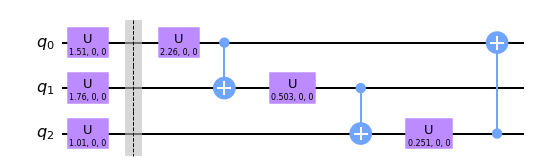

Result density matrix from Alice's state tomography:


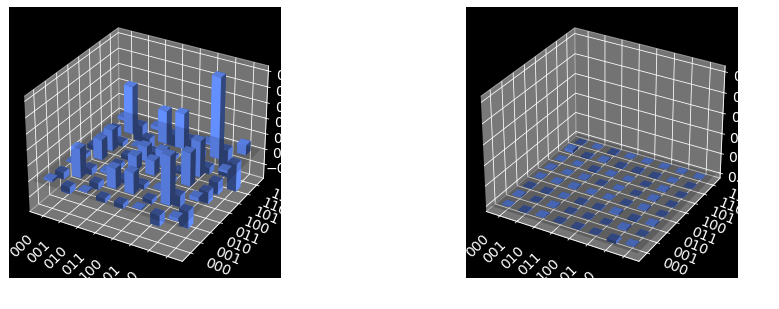

Encryption measurement coherence: (0.9530824545271317-1.981787986636991e-17j)
DECRYPTING...


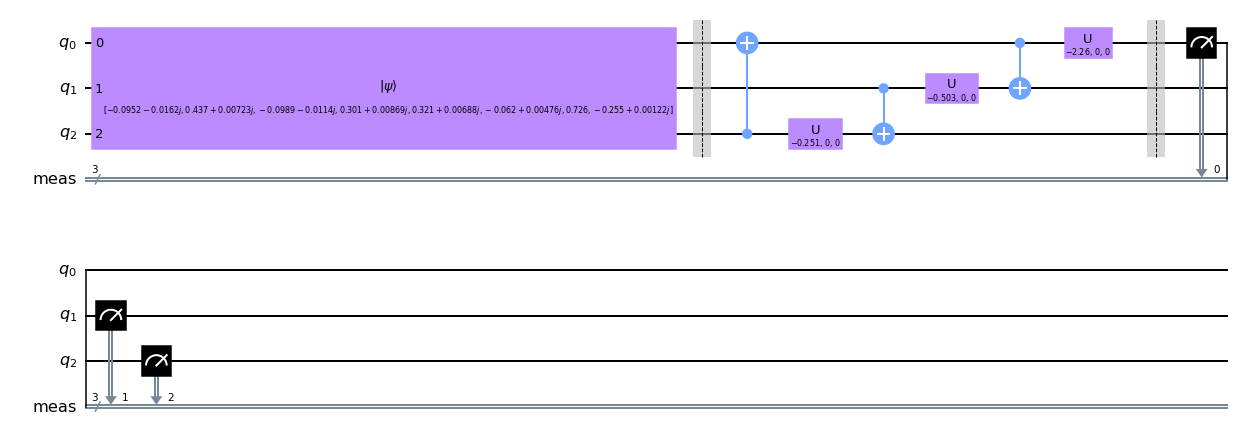

Final measurement results from Bob:


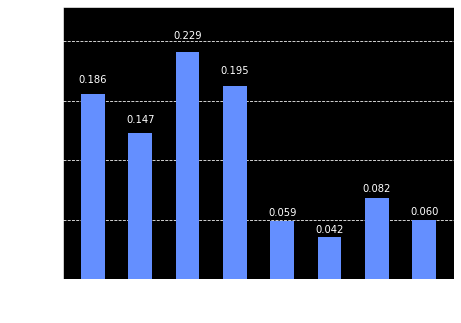

MOI


In [6]:
def encode_ascii_latitudinal(letter):
    offset = ord(letter) - 65
    assert offset >= 0
    assert offset <= 25, "letter must be between A-Z"
    return (offset / 25 * np.pi, 0, 0)

# Spherical encoding not used
# def encode_ascii_spherical(letter):
#     offset = ord(letter) - 65
#     assert offset >= 0
#     assert offset <= 25, "letter must be between A-Z"
#     return (offset // 5 / 5 * np.pi, offset % 5 / 5 * np.pi, 0)

def get_spherical_coordinates(statevector):
    # Convert to polar form:
    r0 = np.abs(statevector[0])
    φ0 = np.angle(statevector[0])

    r1 = np.abs(statevector[1])
    φ1 = np.angle(statevector[1])

    # Calculate the coordinates:
    r = np.sqrt(r0 ** 2 + r1 ** 2)
    θ = 2 * np.arccos(r0 / r)
    φ = φ1 - φ0
    return [r, θ, φ]

def naive_state_from_prob(prob):
    return [np.sqrt(1 - prob), np.sqrt(prob)]

def decode_ascii_latitudinal(prob):
    statevec = naive_state_from_prob(prob)
    offset = get_spherical_coordinates(statevec)[1] / np.pi * 25
    return chr(65 + round(offset))

# TODO
# def decode_ascii_spherical(statevec):

def counts_to_states(N, shots, counts):
    probs = [0] * N
    for (measurement, count) in counts.items():
        for (i, q) in enumerate(reversed(measurement)):
            if q == '1': # sum up all occurrences of 1 for qubit i
                probs[i] += count/shots
    return probs

def inverseU(theta, phi, lamb):
    return (-theta, -lamb, -phi)

# ===================== SETUP =======================
# Alice wants to send the message MOI to Bob securely
# by encrypting it with a symmetric pre-shared-key.
# The encoding of the letters is also known by both
# parties.
message = "MOI"
key_alice = "SEC"
N = len(message)
assert N == len(key_alice)

print(f"ENCRYPTING MESSAGE {message}...")

qc = QuantumCircuit(N)

# =============== MESSAGE ENCODING ==================
# The message is encoded by mapping each letter to a
# qubit on spherical segments of the Bloch sphere.

for (i, (t, p, l)) in enumerate(map(encode_ascii_latitudinal, message)):
    qc.u(t, p, l, i)

qc.barrier()

# ================== THE CIPHER =====================
# The message is encrypted with U3 gates
# parameterized by each letter in the secret key and
# then by operating CNOTs between adjacent qubits.

def encipher(qc, key):
    N = qc.num_qubits
    if N != 1:
        for i in range(N):
            # Apply a U3 gate parameterized by the secret
            # key to qubit i
            qc.u(*encode_ascii_latitudinal(key[i]), i)
            # Apply a CNOT from the previous letter's qubit
            # to the next
            qc.cx(i, (i + 1) % N)

encipher(qc, key_alice)

# qc.h(range(N))

# ================= STATE TOMOGRAPHY ================
# Alice conducts quantum state tomography on the
# quantum circuit to solve the encrypted state vector
# with some confidence. For the coherence of the
# density matrix to be high, the circuit needs to be
# run ~500 times.

qst = StateTomography(qc)
backend = Aer.get_backend('aer_simulator')
data = qst.run(backend, shots=500).block_for_results()

display(qc.draw(output='mpl'))

print("Result density matrix from Alice's state tomography:")
rho = data.analysis_results("state").value
display(plot_state_city(rho))

print("Encryption measurement coherence:", np.trace(rho._data @ rho._data))

# An absolute tolerance of ~0.05 is required for
# consistent results
statevec = rho.to_statevector(atol=0.05)

# ================= TRANSFER TO BOB =================
# The resultant state vector from the density matrix
# Is transferred to Bob using classical networks.
# Bob's quantum computer's state is initialized to
# the received state vector, which is costly and
# unrealistic as the state might be highly entangled.
# 
# In the future, a quantum channel would be ideal.

key_bob = key_alice
print("DECRYPTING...")

qc = QuantumCircuit(N)
qc.initialize(statevec, range(N))
qc.barrier()

# ================== DECRYPTION =====================
# Due to unitary nature of all quantum gates, Bob can
# use a quantum computer to decipher the ciphertext
# using the inverse gates in the reverse order. As
# Bob knows the pre-shared-key and letter encoding,
# he can create the inverse gates trivially.
# CNOT is the inverse of itself and U(-θ, -λ, -φ) is
# the inverse of U(θ, φ, λ).

# qc.h(range(N))

if N != 1:
    for i in reversed(range(N)):
        qc.cx(i, (i + 1) % N)
        qc.u(*inverseU(*encode_ascii_latitudinal(key_bob[i])), i).inverse()

qc.measure_all()
display(qc.draw(output='mpl'))

# ================= BOB MEASUREMENT =================
# Bob runs the circuit multiple times to receive the
# message intact. The decryption seems to be more
# sensitive than encryption when simulated.

shots = 2000
counts = backend.run(qc, shots=shots).result().get_counts()

print("Final measurement results from Bob:")
display(plot_histogram(counts))

print("".join(map(decode_ascii_latitudinal, counts_to_states(N, shots, counts))))